# Import Libraries

In [2]:
import cv2
import pickle
import os
import time
import re
import pytesseract
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mss import mss
from tensorflow.keras.models import load_model

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Setup

### Set path to tesseract if not exported to `$PATH`

In [2]:
path_to_tesseract = 'F:\\Tesseract\\tesseract.exe' #'Your:\\Path\\To\\Tesseract\\exe'

### Ensure proper file structure, all files exist

In [3]:
if os.path.exists('./screenshots/'):
    os.makedirs('./screenshots/')
if os.path.exists('./models/'):
    os.makedirs('./models/')
assert os.path.exists('./models/LCS V2/saved_model.pb'), 'Model does not exist!'
assert os.path.exists('./models/LCS V2/scaler.pkl'), 'Scaler does not exist!'
assert os.path.exists('./models/LCS V2/pixel_coords.pkl'), 'Pixel coords does not exist!'
assert os.path.exists('./models/LCS V2/champ_dict.pkl'), 'Champ dict does not exist!'
assert os.path.exists(path_to_tesseract)

### Set monitor to capture

In [4]:
monitor = 2

Run this cell below if you need to test which monitor number to use. If this cell displays the intended display, continue.

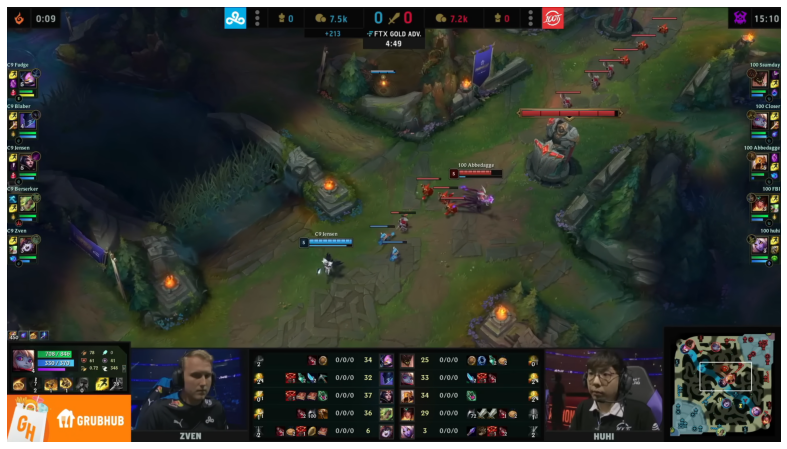

In [5]:
mss().shot(mon=monitor, output='./screenshots/monitor_test.png')
plt.figure(figsize=(15,8))
img = plt.imread('./screenshots/monitor_test.png')
plt.imshow(img)
plt.axis('off')
os.remove('./screenshots/monitor_test.png')

# Setup Draft

### Manually enter champs:
Drafted champions must be manually input into the list below. Most champions are simply their name as they appear in game (first letter capitalized).
Ex. Annie, Olaf, Galio

Some notable exceptions:
1. Aurelion Sol > AurelionSol
1. Bel'Veth > Belveth
1. Cho'Gath > Chogath
1. Dr. Mundo > DrMundo
1. Jarvan IV > JarvanIV
1. Kai'Sa > Kaisa
1. K'Sante > KSante
1. Kha'Zix > Khazix
1. Kog'Maw > KogMaw
1. LeBlanc > Leblanc
1. Lee Sin > LeeSin
1. Master Yi > MasterYi
1. Miss Fortune > MissFortune
1. Nunu & Willump > Nunu
1. Rek'Sai > RekSai
1. Renata Glasc > Renata
1. Tahm Kench > TahmKench
1. Twisted Fate > TwistedFate
1. Vel'Koz > Velkoz
1. Wukong > MonkeyKing
1. Xin Zhao > XinZhao

In [6]:
champ_draft_list = [
    'Fiora', #Blue Top
    'Poppy', #Blue Jungle
    'Taliyah', #Blue Mid
    'Zeri', #Blue AD
    'Alistar', #Blue Support
    'Gnar', #Red Top
    'MonkeyKing', #Red Jungle
    'Zilean', #Red Mid
    'Sivir', #Red AD
    'Lulu' #Red support
]

### Variable initialization and helper functions
Do not edit

In [7]:
pytesseract.pytesseract.tesseract_cmd = path_to_tesseract

def reset_match_info():
    return {
    'timer': 0,
    'blue_team_barons': 0,
    'red_team_barons': 0,
    'blue_team_dragons': 0,
    'red_team_dragons': 0,
    'blue_team_kills': 0,
    'red_team_kills': 0,
    'blue_team_tower': 0,
    'red_team_tower': 0,
    'blue_team_first_tower': 0,
    'red_team_first_tower': 0,
    'player_0_champ': champ_id_list[0],
    'player_0_cs': 0,
    'player_0_k': 0,
    'player_0_d': 0,
    'player_0_a': 0,
    'player_1_champ': champ_id_list[1],
    'player_1_cs': 0,
    'player_1_k': 0,
    'player_1_d': 0,
    'player_1_a': 0,
    'player_2_champ': champ_id_list[2],
    'player_2_cs': 0,
    'player_2_k': 0,
    'player_2_d': 0,
    'player_2_a': 0,
    'player_3_champ': champ_id_list[3],
    'player_3_cs': 0,
    'player_3_k': 0,
    'player_3_d': 0,
    'player_3_a': 0,
    'player_4_champ': champ_id_list[4],
    'player_4_cs': 0,
    'player_4_k': 0,
    'player_4_d': 0,
    'player_4_a': 0,
    'player_5_champ': champ_id_list[5],
    'player_5_cs': 0,
    'player_5_k': 0,
    'player_5_d': 0,
    'player_5_a': 0,
    'player_6_champ': champ_id_list[6],
    'player_6_cs': 0,
    'player_6_k': 0,
    'player_6_d': 0,
    'player_6_a': 0,
    'player_7_champ': champ_id_list[7],
    'player_7_cs': 0,
    'player_7_k': 0,
    'player_7_d': 0,
    'player_7_a': 0,
    'player_8_champ': champ_id_list[8],
    'player_8_cs': 0,
    'player_8_k': 0,
    'player_8_d': 0,
    'player_8_a': 0,
    'player_9_champ': champ_id_list[9],
    'player_9_cs': 0,
    'player_9_k': 0,
    'player_9_d': 0,
    'player_9_a': 0,
    'blue_team_gold': 0,
    'red_team_gold': 0,
    }
    
def reset_df():
    return pd.DataFrame(columns=reset_match_info().keys())

config = '-l eng --psm 7 --oem 1'

with open('./models/champ_dict.pkl', 'rb') as f:
    champ_dict = pickle.load(f)
    
with open('./models/pixel_coords.pkl', 'rb') as f:
    pixel_coords = pickle.load(f)

champ_id_list = [champ_dict[x] for x in champ_draft_list]

df = reset_df()
match_info = reset_match_info()
temp = pd.DataFrame.from_dict([match_info])
df = pd.concat([df, temp], ignore_index=True)

# Output

Run this cell with the game running on the desired monitor.
Cell operation can be interrupted to stop the process.

In [8]:
while (True):
    mss().shot(mon=monitor, output='./screenshots/current.png')
    img = cv2.imread('./screenshots/current.png')
    img = cv2.resize(img, (1920, 1080))
    for key, value in pixel_coords.items():
        cropped = img[value[0]:value[1], value[2]:value[3]]
        if 'kda' in key:
            text = pytesseract.pytesseract.image_to_string(cropped, config=config).strip().split('/')
            if (len(text) > 1):
                match_info[key[:-4] + '_k'] = text[0]
                match_info[key[:-4] + '_d'] = text[1]
                match_info[key[:-4] + '_a'] = text[2]
        elif 'cs' in key or 'kills' in key:
            text = re.findall(r'\d+', pytesseract.pytesseract.image_to_string(cropped, config=config).strip())
            if (len(text) > 0):
                match_info[key] = text[0]
        elif 'gold' in key:
            gold = re.findall(r'\d+', pytesseract.pytesseract.image_to_string(cropped, config=config))
            if (len(gold) > 1):
                match_info[key] = int(gold[0]) * 1000 + int(gold[1]) * 100
        elif 'team_tower' in key:
            text = re.findall(r'\d+', pytesseract.pytesseract.image_to_string(cropped, config=config))
            if len(text) > 0:
                match_info[key] = text[0]
            else:
                backup_text = pytesseract.pytesseract.image_to_string(cropped, config=config)
                if 's' in backup_text:
                    match_info[key] = 5
        elif 'timer' in key:
            timer = re.findall(r'\d+', pytesseract.pytesseract.image_to_string(cropped, config=config))
            timer = [int(x) for x in timer]
            if len(timer) > 1:
                match_info[key] = timer[0] * 60 + timer[1]
        elif key == 'blue_team_barons':
            text = pytesseract.pytesseract.image_to_string(cropped, config=config).lower()
            if 'blue' in text and 'baron' in text:
                match_info['blue_team_barons'] += 1
        elif key == 'red_team_barons':
            text = pytesseract.pytesseract.image_to_string(cropped, config=config).lower()
            if 'red' in text and 'baron' in text:
                match_info['red_team_barons'] += 1
        elif key == 'blue_team_dragons':
            text = pytesseract.pytesseract.image_to_string(cropped, config=config).lower()
            if 'blue' in text and 'dragon' in text:
                match_info['blue_team_dragons'] += 1
        elif 'key' == 'red_team_dragons':
            text = pytesseract.pytesseract.image_to_string(cropped, config=config).lower()
            if 'red' in text and 'dragon' in text:
                match_info['red_team_dragons'] += 1
        elif key == 'blue_team_first_turret':
            text = pytesseract.pytesseract.image_to_string(cropped, config=config).lower()
            if 'blue' in text and 'first' in text and 'turret' in text:
                match_info['blue_team_first_tower'] += 1
        elif key == 'red_team_first_turret':
            text = pytesseract.pytesseract.image_to_string(cropped, config=config).lower()
            if 'red' in text and 'first' in text and 'turret' in text:
                match_info['red_team_first_tower'] += 1
    temp = pd.DataFrame.from_dict([match_info])
    df = pd.concat([df, temp], ignore_index=True)
    
    X = df.copy()
    X = X.tail(1)
    with open('./models/scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
    X = scaler.transform(X)

    model = load_model('./models/LoLWatcher V2')
    prediction = model.predict(X)
    print('Currently Blue side has a', np.round(prediction[0][0] * 100, 2), '% chance of  winning.', end='\r')
    time.sleep(5)

IndexError: list index out of range

In [9]:
df

,timer,blue_team_barons,red_team_barons,blue_team_dragons,red_team_dragons,blue_team_kills,red_team_kills,blue_team_tower,red_team_tower,blue_team_first_tower,...,player_8_k,player_8_d,player_8_a,player_9_champ,player_9_cs,player_9_k,player_9_d,player_9_a,blue_team_gold,red_team_gold
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,117,0,0,0,0,0,0
1,291,0,0,0,0,0,0,0,0,0,...,0,0,0,117,3,0,0,0,7500,7300
2,301,0,0,0,0,0,0,0,0,0,...,0,0,0,117,3,0,0,0,7700,7600
3,311,0,0,0,0,0,0,0,0,0,...,0,0,0,117,3,0,0,0,7900,7800
4,322,0,0,0,0,0,0,0,0,0,...,0,0,0,117,3,0,0,0,8100,8000
5,322,0,0,0,0,0,0,0,0,0,...,0,0,0,117,3,0,0,0,8400,8200
6,342,0,0,0,0,0,0,0,0,0,...,0,0,0,117,3,0,0,0,8600,8200
7,342,0,0,0,0,1,0,0,0,0,...,0,0,0,117,3,0,0,0,9400,8800
8,364,0,0,0,0,1,0,0,0,0,...,0,0,0,117,3,0,0,0,9900,8800
9,374,0,0,0,0,1,0,0,0,0,...,0,0,0,117,4,0,0,0,10200,9200
